In [1]:
import igraph as ig
import matplotlib.pyplot as plt

In [2]:
from scipy.spatial import Delaunay

In [3]:
import numpy as np
import random
import pandas as pd
import math

In [4]:
def LineGenerate(lenght, m):
    """
    Creating a line with m random segments
    """
    line = np.zeros(lenght,)
    ab = np.array(sorted(random.sample(range(0, lenght-1), m*2))) # random start and end of the segments
    ab = ab.reshape((m,2)) # start and end of the segments coordinates
    return ab

In [5]:
def MultipleLines(line_lenght, min_seg, max_seg, line_num, max_hight):
    seg_hights = sorted(random.sample(range(0, max_hight), line_num))
    lines = pd.DataFrame(columns = ['Start','End', 'Height', 'Line'])
    for i in range(line_num):
        line =  pd.DataFrame(LineGenerate(line_lenght, random.randrange(min_seg, max_seg)), columns = ['Start','End'])
        line["Height"] = seg_hights[i]
        line["Line"] = i
        lines = pd.concat([lines,line], ignore_index=True)
    return lines

In [6]:
l = 50 # max line lenght 
min_seg = 2 # min segments per line
max_seg = 5 # max segments per line
n = 5 # number of lines
max_hight = 50 # max hight of the higthest segment

In [7]:
lines = MultipleLines(l, min_seg, max_seg, n, max_hight)

In [8]:
lines

Start End Height Line
0     28  33      9    0
1     38  45      9    0
2      0   3     32    1
3     20  35     32    1
4     40  42     32    1
5     43  47     32    1
6      2   7     40    2
7     13  28     40    2
8     37  38     40    2
9     43  44     40    2
10    25  28     44    3
11    35  39     44    3
12    40  45     44    3
13    17  21     45    4
14    25  39     45    4

In [9]:
n_vertices = lines.shape[0]*2

In [10]:
starts = lines['Start'].to_numpy()
ends = lines['End'].to_numpy()
hight = lines['Height'].to_numpy()

In [11]:
x = np.zeros(lines.shape[0]*2)
y =  np.zeros(lines.shape[0]*2)

In [12]:
for i in range(lines.shape[0]):
    x[i*2] = starts[i]
    x[i*2+1] = ends[i]
    y[i*2] = hight[i]
    y[i*2+1] = hight[i]    

In [13]:
edge = np.zeros([lines.shape[0],2])

In [14]:
for i in range(lines.shape[0]):
    edge[i] = [i*2,i*2+1]

In [15]:
g = ig.Graph(n_vertices, edge)

In [16]:
g.vs['x'] = x
g.vs['y'] = y

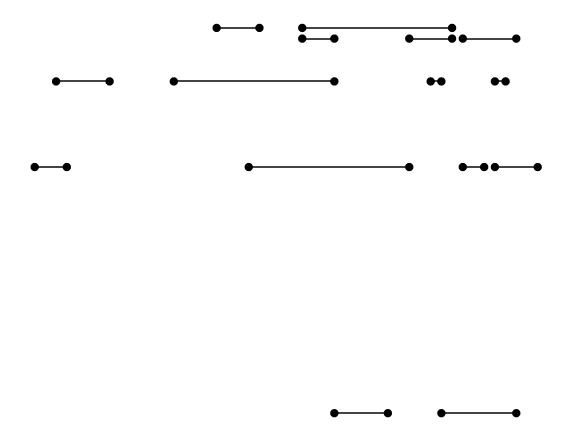

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
ig.plot(
    g,
    target=ax,
    layout='auto',
    vertex_size=0.4,
    vertex_frame_width=4.0,
)

plt.show()

In [18]:
def PlotTheGraph(g):
    edge_width = [2 + 10 * int(is_segment) for is_segment in g.es["is_segment"]]
    fig, ax = plt.subplots(figsize=(50,50))
    ig.plot(
        g,
        target=ax,
        layout='auto',
        vertex_size=0.5,
        vertex_frame_width=4.0,
        edge_width = edge_width,
    )
    plt.show()

In [19]:
def AddSegments(g, segments):
    for i in range(segments.shape[0]):
        g.es[g.get_eid(int(segments[i,0]), int(segments[i,1]))]["is_segment"] = True    
    g.es["is_segment"] = [False if is_segment is None else is_segment for is_segment in g.es["is_segment"]]

In [20]:
def WeighEdges(g):
    for i in range(len(g.get_edgelist())):
        edge_nodes = g.get_edgelist()[i]
        x_dist = g.vs[edge_nodes[1]]['x'] - g.vs[edge_nodes[0]]['x']
        y_dist = g.vs[edge_nodes[1]]['y'] - g.vs[edge_nodes[0]]['y']
        
        distance = math.sqrt(x_dist**2+y_dist**2)        
        g.es[i]["weight"] = distance

In [21]:
def BuildDelaunay(g, segments):
    g_delaunay = g.copy()
    layout = g_delaunay.layout_auto()   
    delaunay = Delaunay(layout.coords)
    for tri in delaunay.simplices:
        g_delaunay.add_edges([
            (tri[0], tri[1]),
            (tri[1], tri[2]),
            (tri[0], tri[2]),
        ])
    g_delaunay.simplify()
    
    WeighEdges(g_delaunay)
    AddSegments(g_delaunay, segments)
    PlotTheGraph(g_delaunay)
    return g_delaunay

In [22]:
def BuildFull(n_vertices, segments):
    g_comp = g.complementer(loops=False)
    g_full = g|g_comp
    layout = g_full.layout_auto()   
    g_full.simplify()
    
    WeighEdges(g_full)
    AddSegments(g_full, segments)
    PlotTheGraph(g_full)
    return g_full

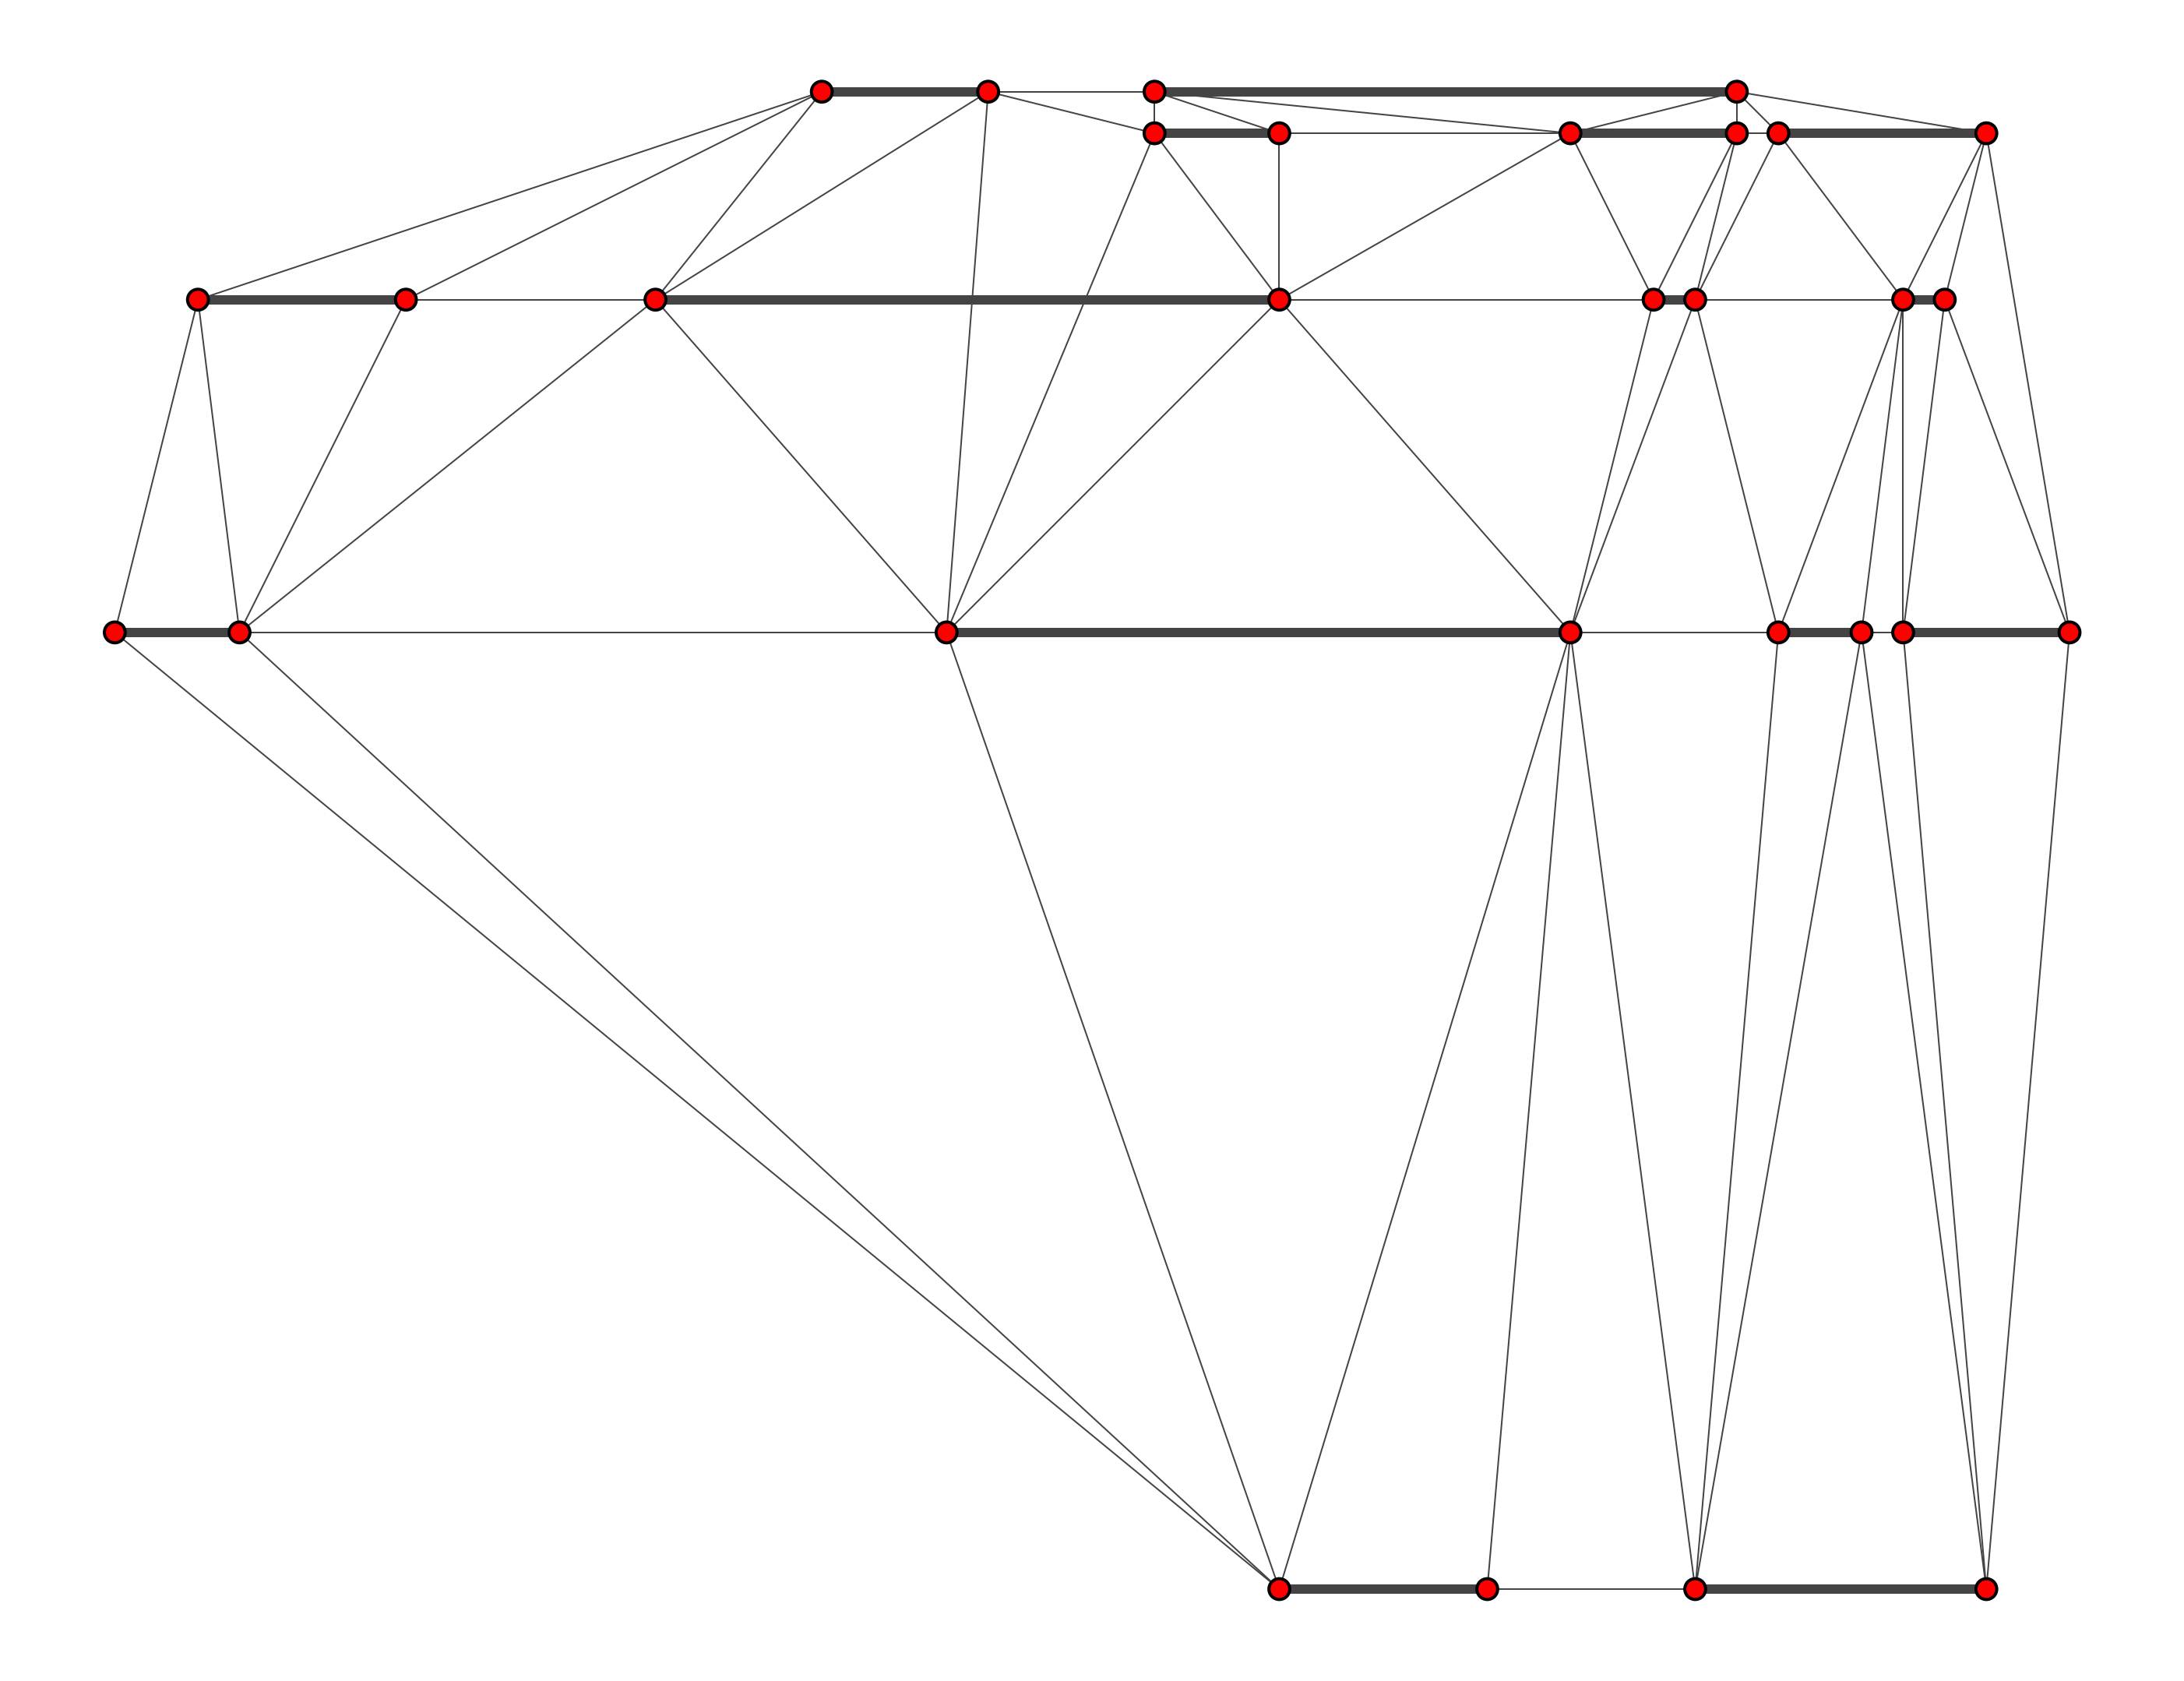

In [23]:
g_delaunay = BuildDelaunay(g, edge)

In [24]:
def DeleteLongEdges(g, max_lenght):
    for i in reversed(range(len(g.get_edgelist()))):
        if (g.es[i]["weight"]>max_lenght) and (g.es[i]["is_segment"]==False):
            g.delete_edges(i)

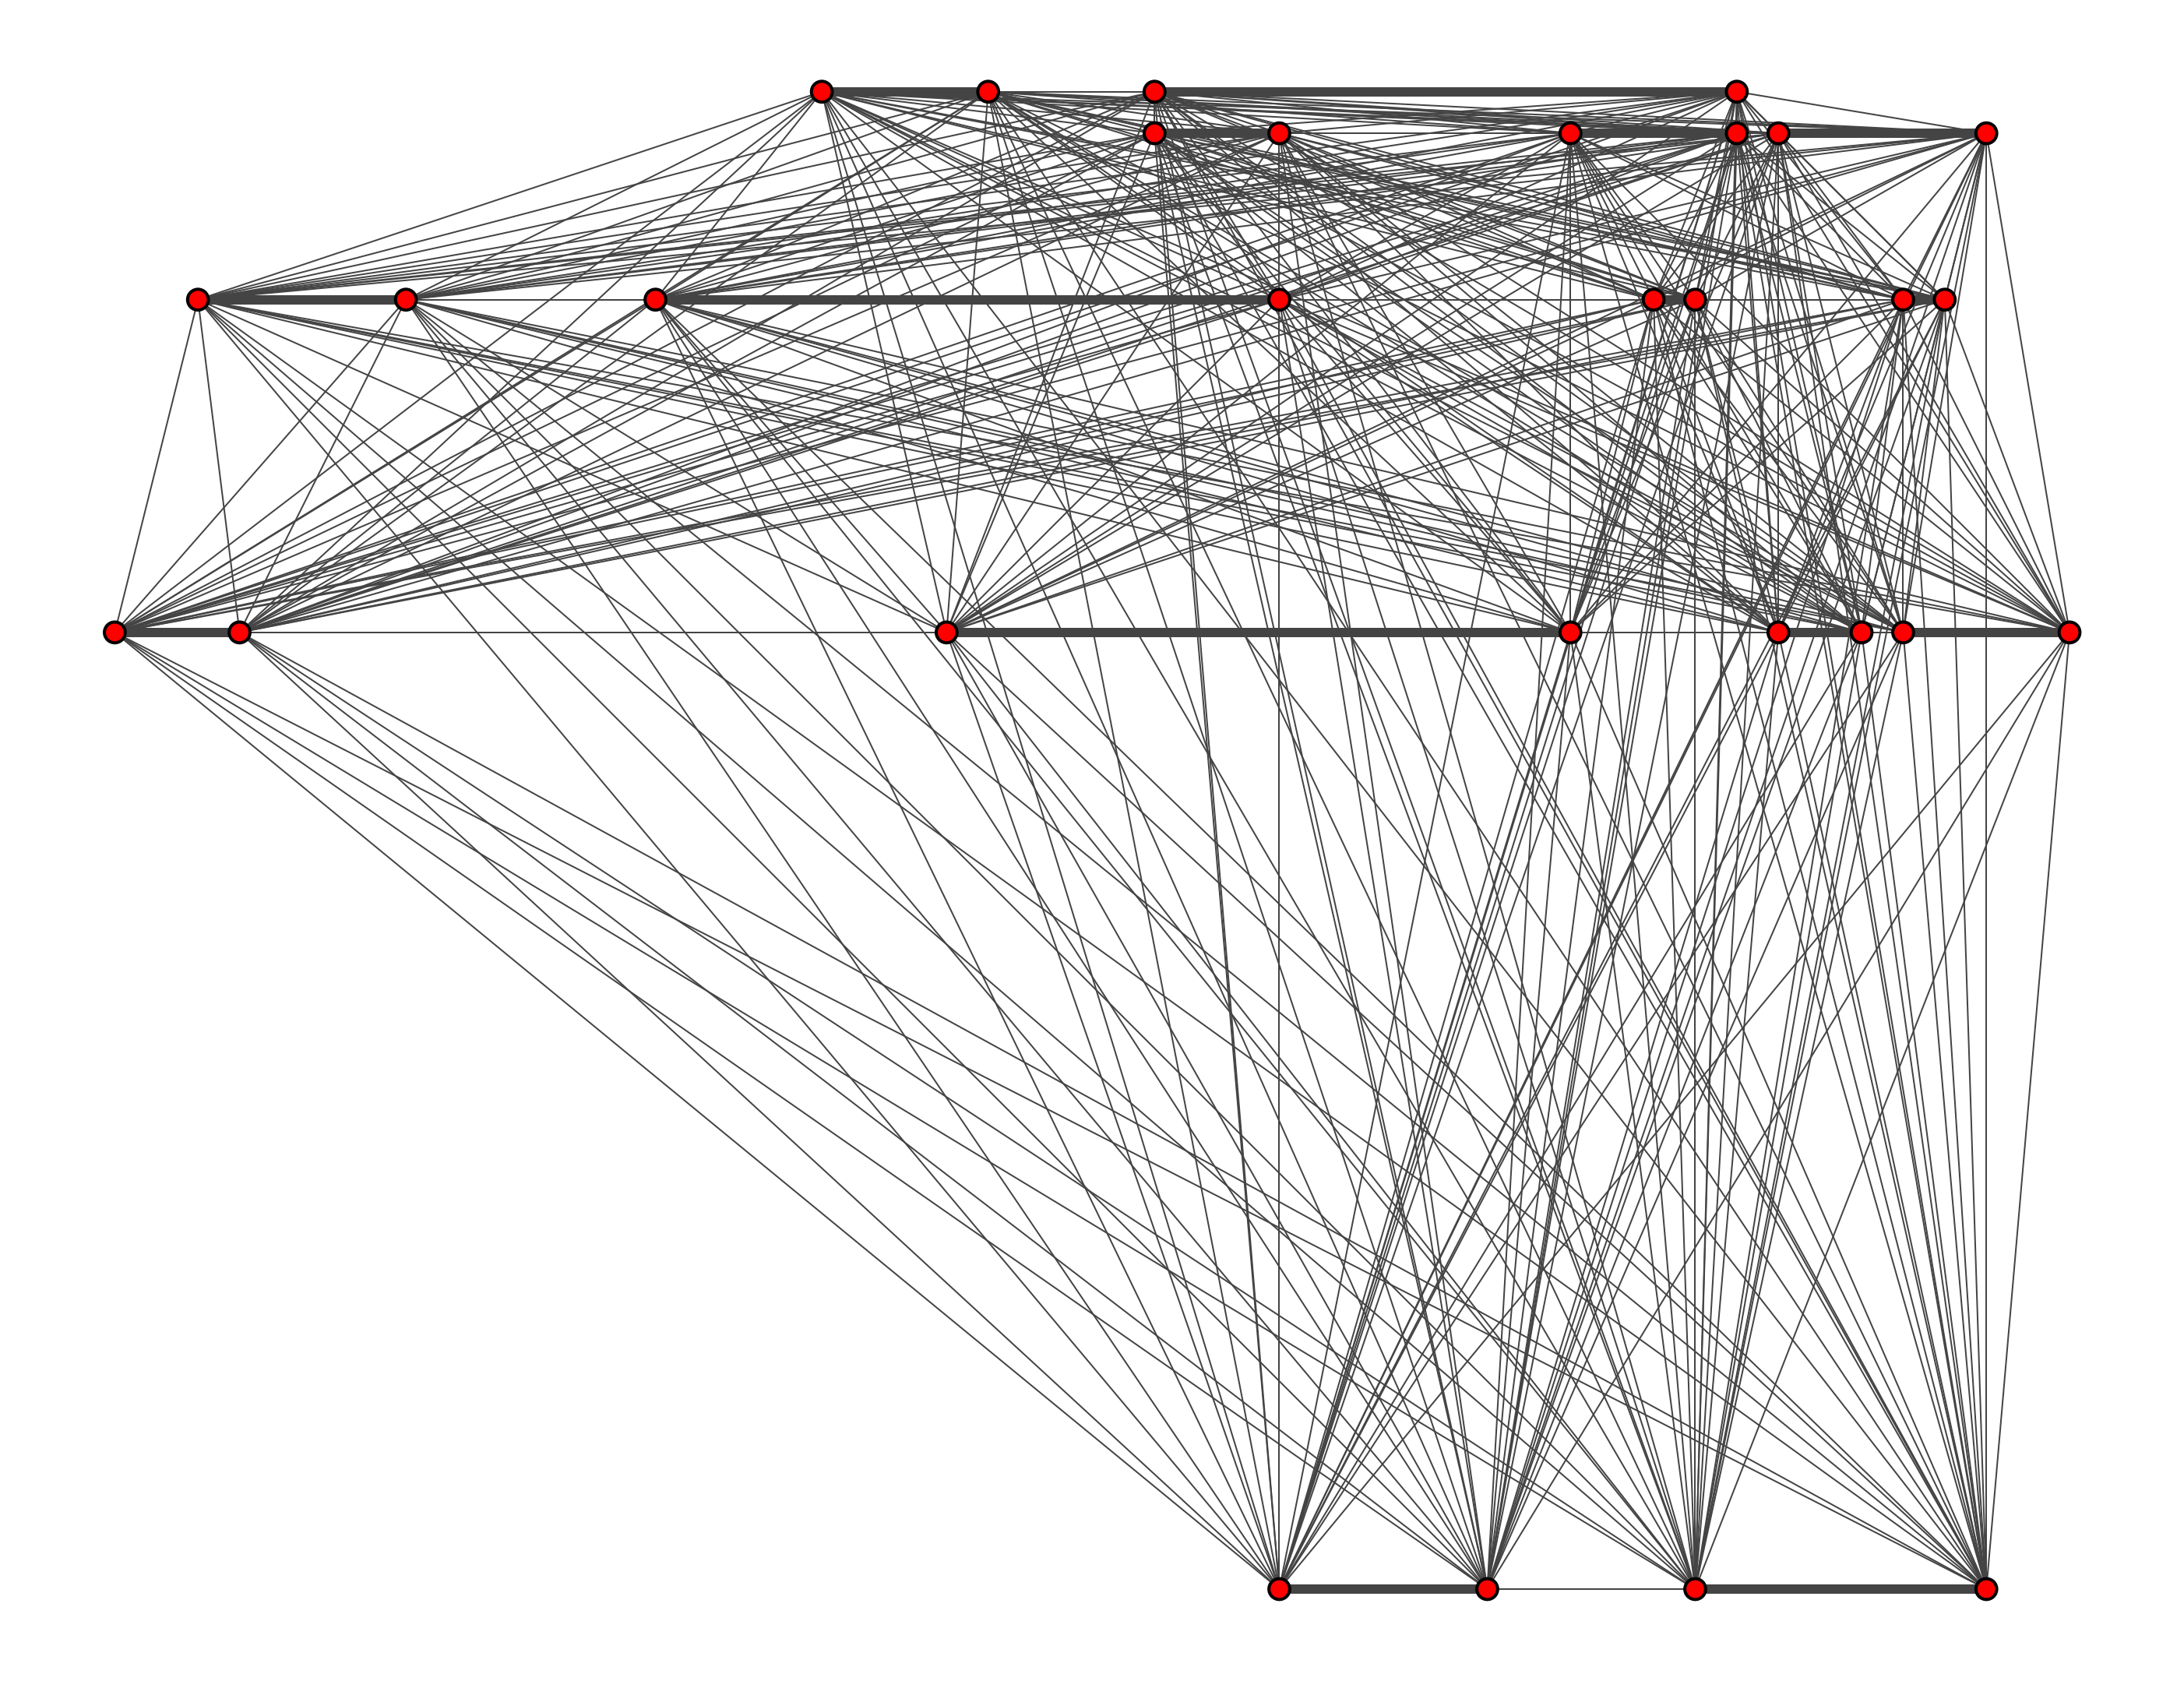

In [25]:
g_full = BuildFull(n_vertices, edge)

In [26]:
def BuildMaxLenghtGraph(g, max_lenght):
    g_max_lenght = g.copy()
    
    DeleteLongEdges(g_max_lenght, max_lenght)
    
    PlotTheGraph(g_max_lenght)
    return g_max_lenght

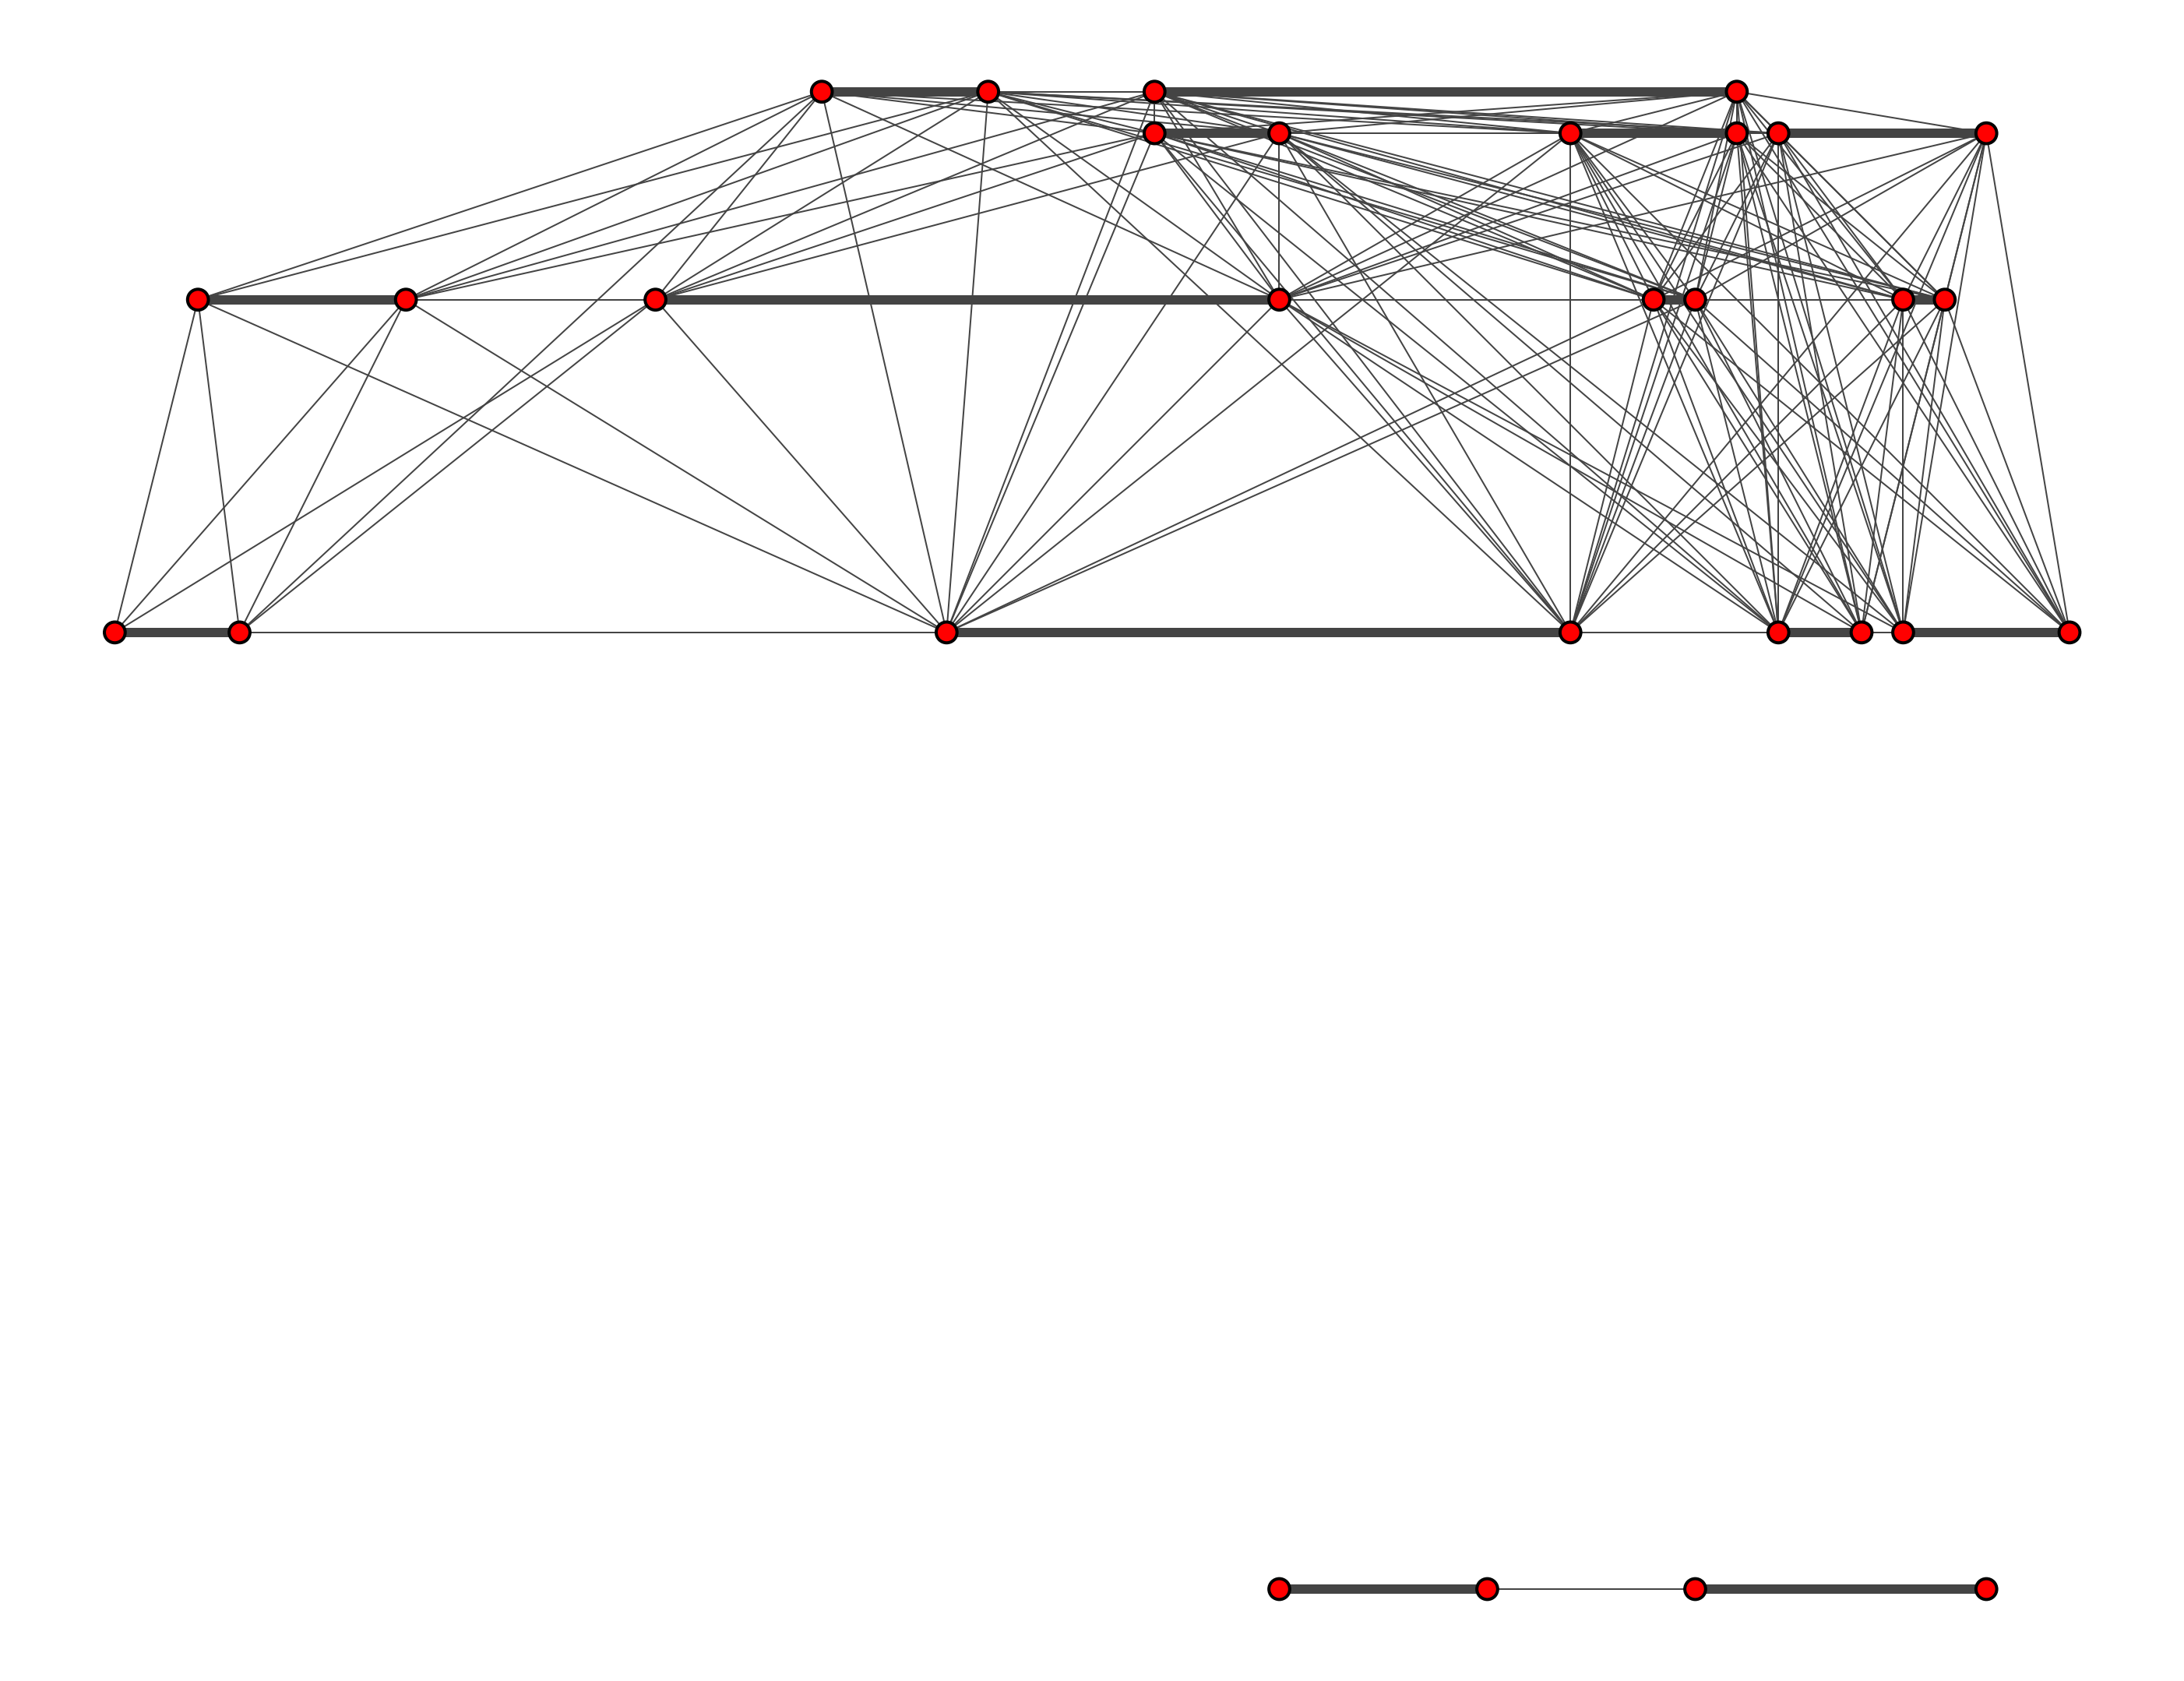

In [27]:
max_lenght = 20
g_max_lenght = BuildMaxLenghtGraph(g_full, max_lenght)

In [106]:
def DeleteNotClosest(g, n):
    for i in reversed(range(g.vcount())):
        v = g.vs[i]
        if v.degree()>n: 
            edge = v.incident()
            w = np.empty(0)
            for j in range(len(edge)):
                w = np.append(w, edge[j]["weight"]) 
            sorted_weights = np.sort(w)
        
            max_lenght = sorted_weights[n-1]
        
            for k in reversed([ed.index for ed in edge]):
                if 
                if (g.es[k]["weight"] > max_lenght) and (g.es[k]["is_segment"]==False):
                    g.delete_edges(k)

In [107]:
def BuildNClosest(g, n):
    g_n_closest = g.copy()
    
    DeleteNotClosest(g_n_closest, n)
    
    PlotTheGraph(g_n_closest)
    return g_n_closest

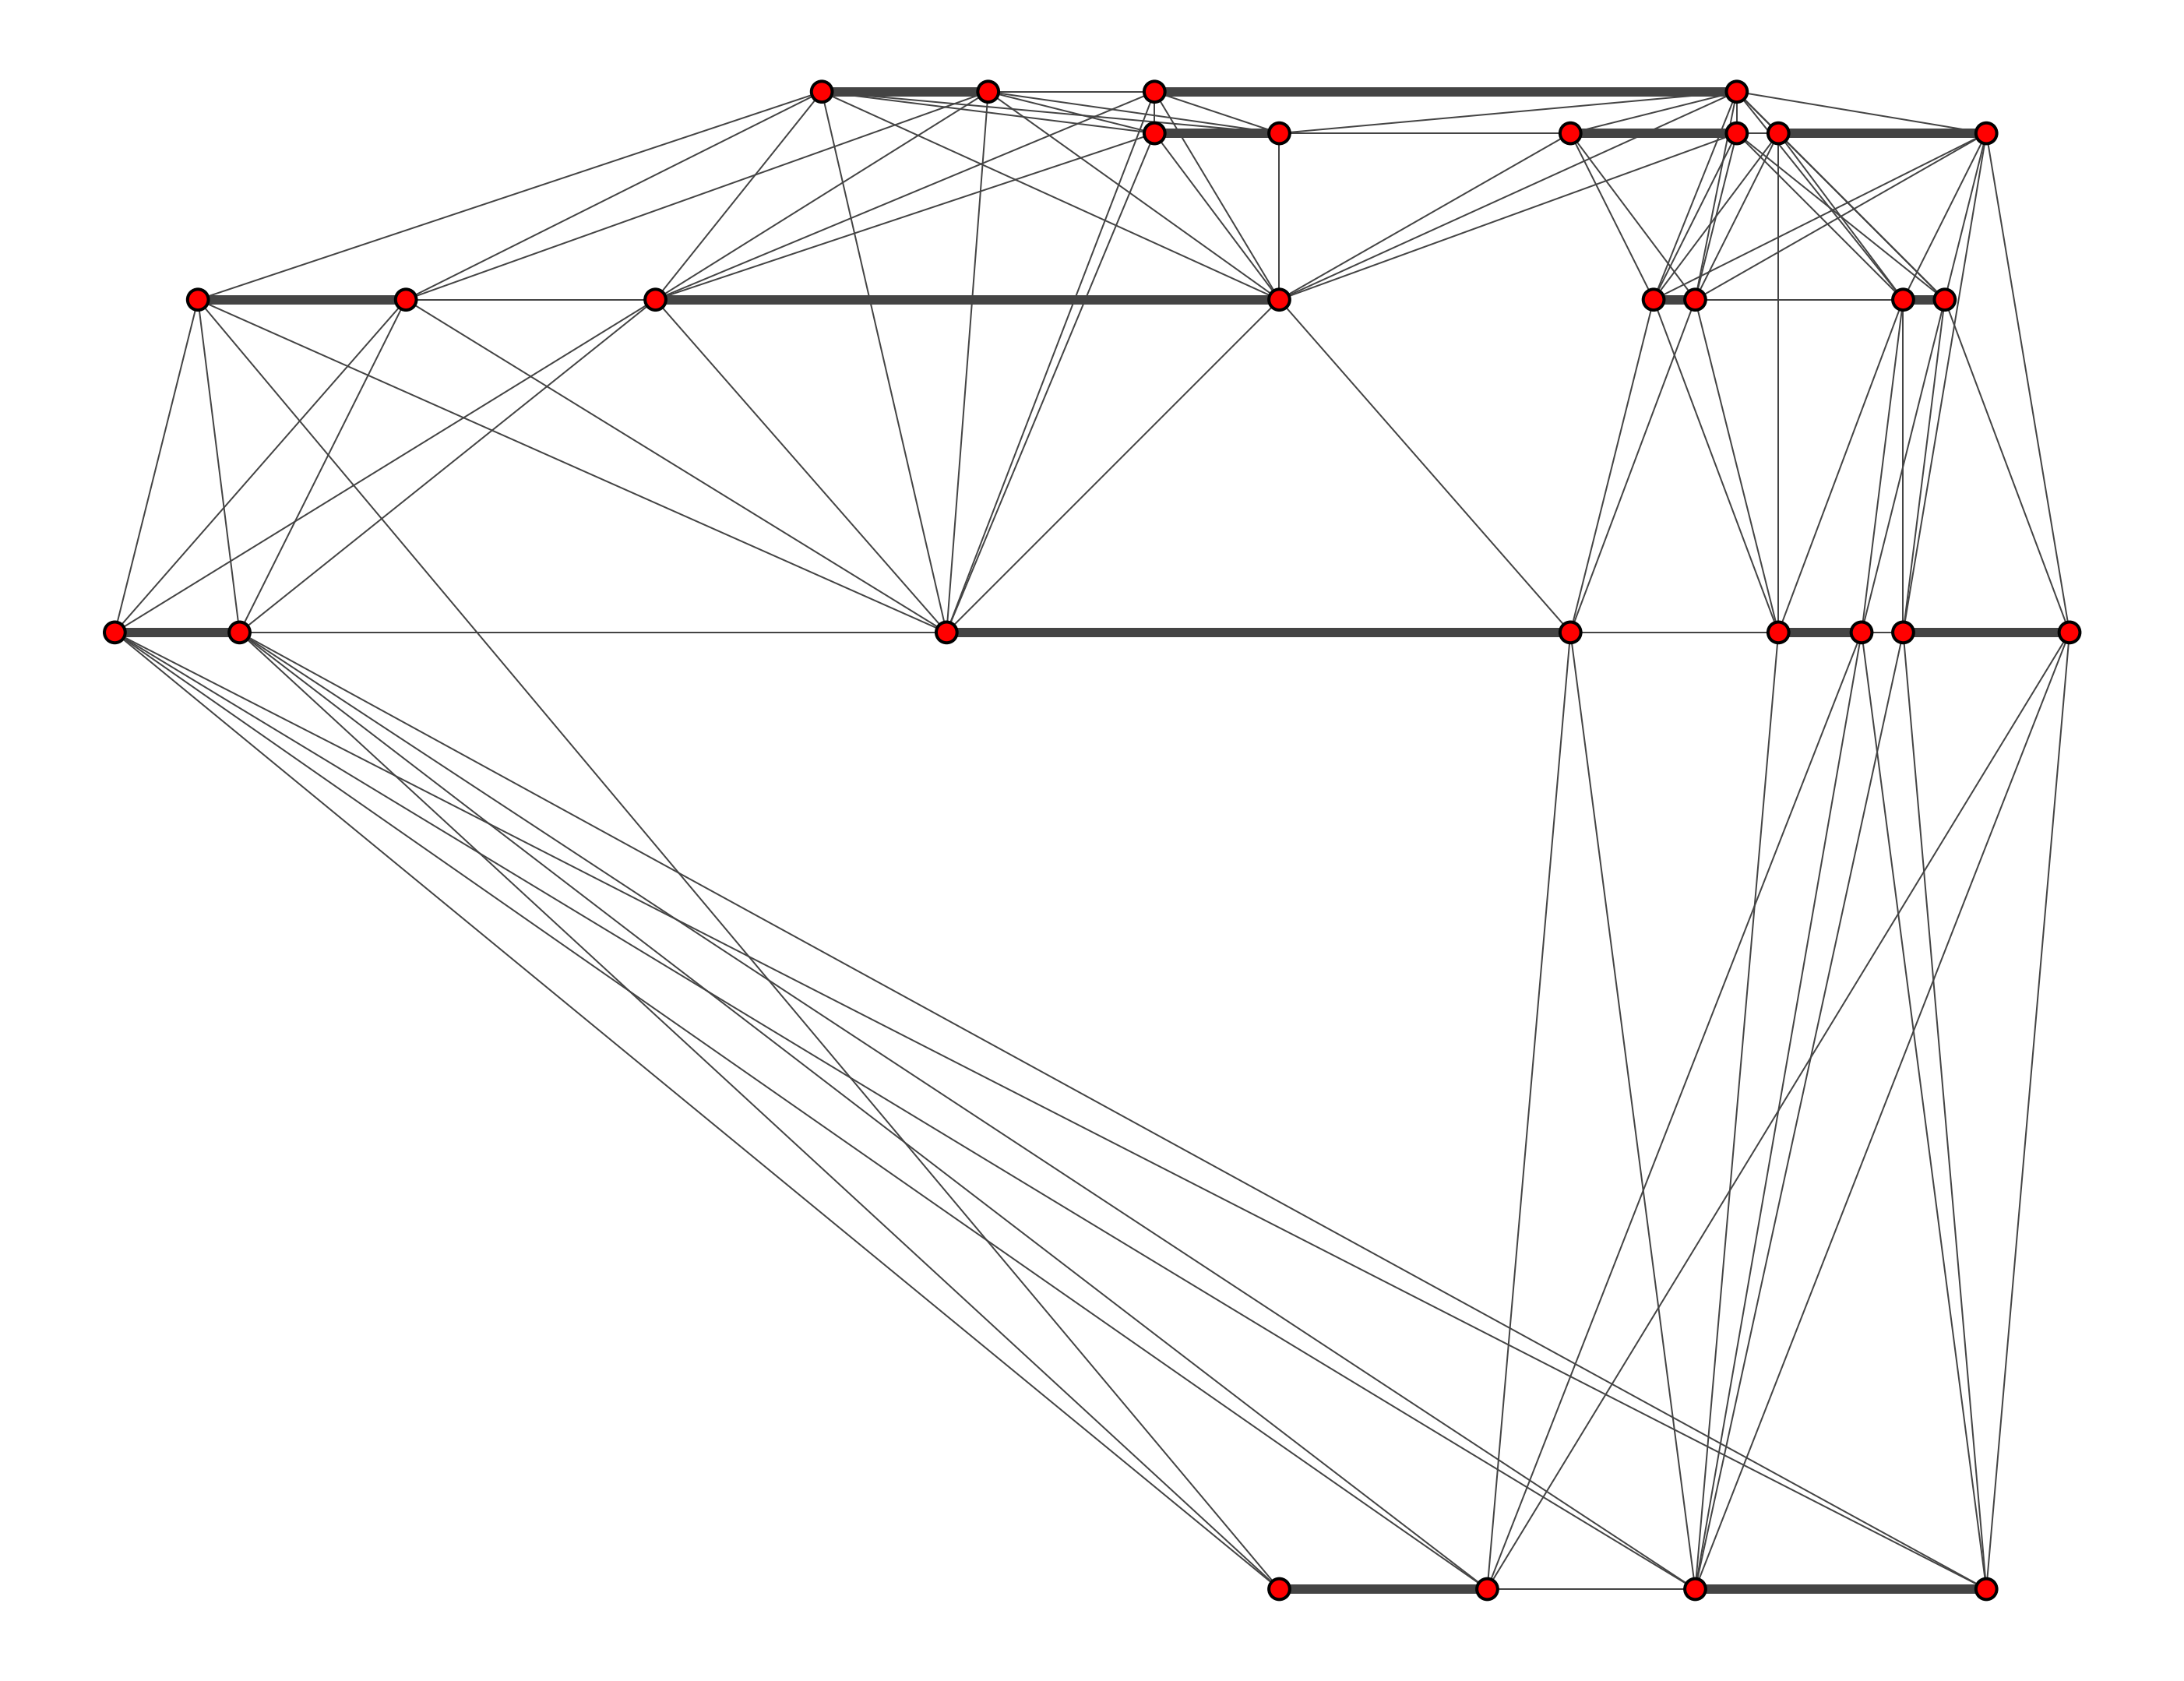

In [117]:
g_n_closest = BuildNClosest(g_full, 10)